<a href="https://colab.research.google.com/github/DevKor-Team/MRDC-Challenge/blob/jo/jo/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!pip install --upgrade -q fastai

     |████████████████████████████████| 204 kB 6.8 MB/s 
     |████████████████████████████████| 61 kB 9.6 MB/s 


In [ ]:
BASE_DIR = '/content/gdrive/MyDrive/ML/MRDC-competition/data'

In [ ]:
# 이미지 압축 해제
!unzip -q /content/gdrive/MyDrive/ML/MRDC-competition/data/Images.zip -d /content/gdrive/MyDrive/ML/MRDC-competition/data/images

In [ ]:
from fastai.vision.all import *

In [ ]:
# Load Data
import os

train = pd.read_csv(os.path.join(BASE_DIR, 'Train.csv'))
print(train.shape)
train.head()

(5340, 2)


,Image_id,Label
0,id_004wknd7qd.jpg,blast
1,id_004wknd7qd_rgn.jpg,blast
2,id_005sitfgr2.jpg,brown
3,id_005sitfgr2_rgn.jpg,brown
4,id_00stp9t6m6.jpg,blast


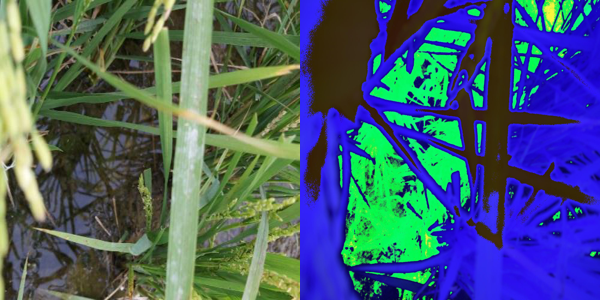

In [ ]:
out = Image.new('RGB', (600, 300))
out.paste(Image.open(os.path.join(BASE_DIR, 'images/id_004wknd7qd.jpg')).resize((300, 300)), (0, 0))
out.paste(Image.open(os.path.join(BASE_DIR, 'images/id_004wknd7qd_rgn.jpg')).resize((300, 300)), (300, 0))
out

In [ ]:
train.value_counts(['Label'])

Label  
blast      2988
brown      1532
healthy     820
dtype: int64

In [ ]:
train_rgb.value_counts(['Label'])

Label  
blast      1494
brown       766
healthy     410
dtype: int64

In [ ]:
from PIL import Image

img1 = Image.open(os.path.join(BASE_DIR, 'images/id_004wknd7qd.jpg'))
img1.size

(500, 400)

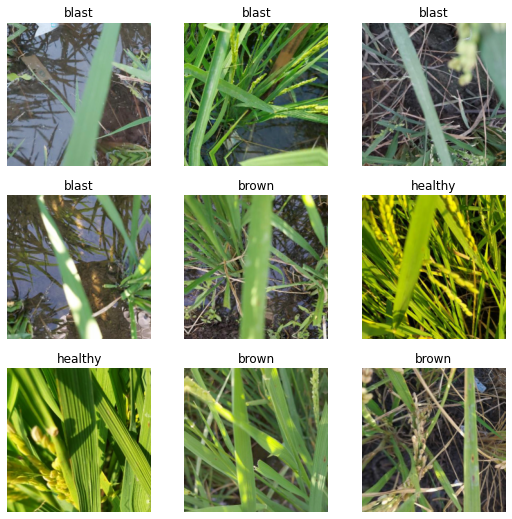

In [ ]:
# dataloader 만들기

train_rgb = train.loc[~train['Image_id'].str.contains('_rgn')]
dls = ImageDataLoaders.from_df(train_rgb, fn_col='Image_id', label_col='Label',
                               folder=BASE_DIR+'/images', item_tfms=Resize(400),
                               batch_tfms=aug_transforms(size=224))
dls.show_batch()

In [ ]:
# training model
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(4)  # 인자는 에폭을 뜻함

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.456926,0.712927,0.241573,00:21


epoch,train_loss,valid_loss,error_rate,time
0,0.923080,0.513981,0.198502,00:21
1,0.744932,0.409963,0.138577,00:21
2,0.560640,0.387493,0.129213,00:21
3,0.415631,0.362338,0.121723,00:21


In [ ]:
learn = vision_learner(dls, resnet34, loss_func=CrossEntropyLossFlat(), metrics=error_rate)
learn.fine_tune(4)  # 인자는 에폭을 뜻함

epoch,train_loss,valid_loss,error_rate,time
0,1.472935,0.690291,0.243446,00:19


epoch,train_loss,valid_loss,error_rate,time
0,0.889015,0.508424,0.172285,00:21
1,0.676765,0.451637,0.146067,00:20
2,0.499384,0.392127,0.116105,00:20
3,0.399441,0.357917,0.104869,00:20


In [ ]:
es = EarlyStoppingCallback(monitor='valid_loss', min_delta=0.1, patience=2)
learn.fine_tune(50, cbs=es)

epoch,train_loss,valid_loss,error_rate,time
0,0.286561,0.443224,0.114232,00:21


epoch,train_loss,valid_loss,error_rate,time
0,0.275600,0.380655,0.114232,00:20
1,0.228643,0.355848,0.106742,00:20
2,0.198245,0.328388,0.089888,00:20


No improvement since epoch 0: early stopping


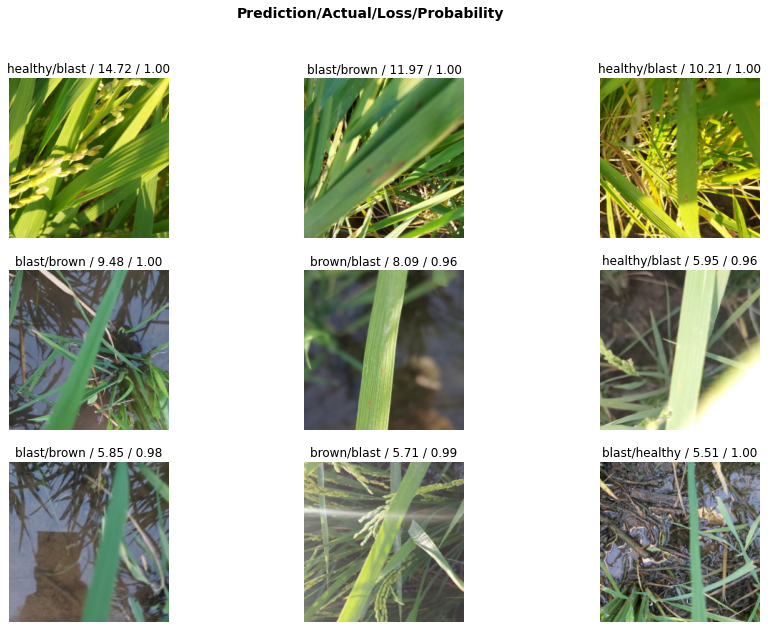

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,10))

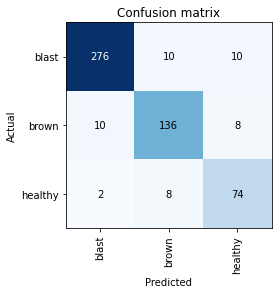

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
test = pd.read_csv(os.path.join(BASE_DIR, 'Test.csv'))
test.head()

,Image_id
0,id_00vl5wvxq3.jpg
1,id_00vl5wvxq3_rgn.jpg
2,id_01hu05mtch.jpg
3,id_01hu05mtch_rgn.jpg
4,id_030ln10ewn.jpg


In [ ]:
ss = pd.read_csv(os.path.join(BASE_DIR, 'SampleSubmission.csv'))
ss.head()

,Image_id,blast,brown,healthy
0,id_00vl5wvxq3.jpg,0.0,0.0,0.0
1,id_01hu05mtch.jpg,0.0,0.0,0.0
2,id_030ln10ewn.jpg,0.0,0.0,0.0
3,id_03z57m8xht.jpg,0.0,0.0,0.0
4,id_04ngep1w4b.jpg,0.0,0.0,0.0


In [ ]:
test = test.loc[~test['Image_id'].str.contains('_rgn')]
preds, _ = learn.get_preds(dl=dls.test_dl(test))
preds.shape

torch.Size([1145, 3])

In [ ]:
learn.dls.vocab

['blast', 'brown', 'healthy']

In [ ]:
preds[0]

TensorBase([9.9805e-01, 1.2616e-03, 6.9312e-04])

In [ ]:
submission = pd.DataFrame({'Image_id': test['Image_id']})
for i, label in enumerate(learn.dls.vocab):
  submission[label] = preds[:, i].numpy()
submission.head()

,Image_id,blast,brown,healthy
0,id_00vl5wvxq3.jpg,0.998045,0.001262,0.000693
2,id_01hu05mtch.jpg,0.001904,0.997678,0.000418
4,id_030ln10ewn.jpg,0.226552,0.404558,0.368890
6,id_03z57m8xht.jpg,0.999647,0.000006,0.000347
8,id_04ngep1w4b.jpg,0.996125,0.003401,0.000474


In [ ]:
submission.to_csv('baseline.csv', index=False)

Baseline 끝. 다양한 시도를 해보장.

In [ ]:
# rgn data 추가

